In [1]:
import ee
import urllib.request
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNGiHkhkHpx7mCj0YIlApqX775xLxZcHkSFh4-DbmVa8MFZlHy0Vy8

Successfully saved authorization token.


# Data downloads

## Satellite images

### Attempt 1: gee tools

In [ ]:
import geetools

In [ ]:
# Define an ImageCollection
site = ee.Geometry.Point([-72, -42]).buffer(1000) # creates a centre point about which to create a buffer box
collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterBounds(site).limit(5)

# Set parameters
bands = ['B2', 'B3', 'B4'] # visible spectrum

scale = 30

name_pattern = 'new image'
date_pattern = 'ddMMMy'
folder = 'Earth_Images'
data_type = 'uint32'
extra = dict(sat='L8SR')
region = site
# Export
tasks = geetools.batch.Export.imagecollection.toDrive(
    collection=collection,
    folder=folder,
    region=region,
    namePattern=name_pattern,
    scale=scale,
    dataType=data_type,
    datePattern=date_pattern,
    extra=extra,
    verbose=True,
    maxPixels=int(1e13)
)

Struggling to access the data appropriately. Gives a some data but the exporting to Google Drive has limitations due to limited personal storage space

### Attempt 2: URLLib to import files to local

Simple process to create a single image

In [22]:
vis_min = 0  # Visualization settings for the image
vis_max = 10_000 # Visualization settings for the image
vis_bands = ['B4', 'B3', 'B2'] # Includes the bands for RGB 
imageDimensions = '512x512' # Set image size: '512x512' for CNN model

id_ = 1

# Centre point for satellite image
longitude = 26.43
latitude = 45.5

center = ee.Geometry.Point(longitude,latitude)

# Import Sentinel 2 data
s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
  .filterBounds(center)
  .sort('CLOUDY_PIXEL_PERCENTAGE',True)
  .filterDate('2021-06-01', '2021-07-30')
  .first()
)

# try:
global sentinel_footprint
exportArea = (ee.Geometry.BBox(west=longitude - 0.4,
                               south=latitude - 0.4,
                               east=longitude + 0.4,
                               north=latitude + 0.4))
# except:
#     print("No Footprint found")
#     continue


# This part is nicer in the JavaScript version, but I did not get it running for Python yet

s2Vis = {
    'region': exportArea,
    'dimensions': imageDimensions,
    'format': 'png',
    'min': vis_min,
    'max': vis_max,
    'bands': vis_bands,
    'gamma':1.5
}

s2_url = (s2.getThumbURL(s2Vis))


urllib.request.urlretrieve(s2_url, f"../raw_data/prediction/satellite_{longitude}_{latitude}.png")
print(s2_url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5cfcc04908afd4232008689319ccc6cc-1672931e7f0b421546924488c63e24bc:getPixels


Multiple images, need a dataframe to iterate through

In [64]:
locations = pd.read_csv('../raw_data/c:\downloads\centrepoints.csv')

locations

,numb,longitude,latitude
0,0,-109.0000,37.0000
1,1,-109.0000,37.0427
2,2,-109.0000,37.0854
3,3,-109.0000,37.1281
4,4,-109.0000,37.1708
...,...,...,...
15411,15411,-102.0399,40.8003
15412,15412,-102.0399,40.8430
15413,15413,-102.0399,40.8857
15414,15414,-102.0399,40.9284


Code to import and store the image

In [53]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['B4', 'B3', 'B2'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 4694 # where you will start your loop based on the dataframe
end_location = 15415 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']

    center = ee.Geometry.Point(longitude,latitude)

    # Import Sentinel 2 data
    s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(center)
      .sort('CLOUDY_PIXEL_PERCENTAGE',True)
      .filterDate('2021-06-01', '202-07-30')
      .first()
    )

    try:
        global sentinel_footprint
        exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                       south=latitude - 0.02135,
                                       east=longitude + 0.02135,
                                       north=latitude + 0.02135))
    except:
        print("No Footprint found")
        continue


    # This part is nicer in the JavaScript version, but I did not get it running for Python yet

    s2Vis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands,
        'gamma':1.5
    }

    s2_url = (s2.getThumbURL(s2Vis))

    try:
        urllib.request.urlretrieve(s2_url, f"../raw_data/zoomed_photos/image{id_}_{round(longitude,2)}_{round(latitude,2)}.png")
        print(f'finished number {id_} at {round(longitude,2)} : {round(latitude,2)}')
    except:
        print(f"No link for image {id_} found")
        continue
        
    if id_ == end_location:
        print('Congrats 🎊🎉🥳')

finished number 3519 at -107.42 : 38.75
finished number 3520 at -107.42 : 38.79
finished number 3521 at -107.42 : 38.84
finished number 3522 at -107.42 : 38.88
finished number 3523 at -107.42 : 38.92
finished number 3524 at -107.42 : 38.96
finished number 3525 at -107.42 : 39.01
finished number 3526 at -107.42 : 39.05
finished number 3527 at -107.42 : 39.09
finished number 3528 at -107.42 : 39.14
finished number 3529 at -107.42 : 39.18
finished number 3530 at -107.42 : 39.22
finished number 3531 at -107.42 : 39.26
finished number 3532 at -107.42 : 39.31
finished number 3533 at -107.42 : 39.35
finished number 3534 at -107.42 : 39.39
finished number 3535 at -107.42 : 39.43
finished number 3536 at -107.42 : 39.48
finished number 3537 at -107.42 : 39.52
finished number 3538 at -107.42 : 39.56
finished number 3539 at -107.42 : 39.6
finished number 3540 at -107.42 : 39.65
finished number 3541 at -107.42 : 39.69
finished number 3542 at -107.42 : 39.73
finished number 3543 at -107.42 : 39.78
f

finished number 3725 at -107.33 : 39.52
finished number 3726 at -107.33 : 39.56
finished number 3727 at -107.33 : 39.6
finished number 3728 at -107.33 : 39.65
finished number 3729 at -107.33 : 39.69
finished number 3730 at -107.33 : 39.73
finished number 3731 at -107.33 : 39.78
finished number 3732 at -107.33 : 39.82
finished number 3733 at -107.33 : 39.86
finished number 3734 at -107.33 : 39.9
finished number 3735 at -107.33 : 39.95
finished number 3736 at -107.33 : 39.99
finished number 3737 at -107.33 : 40.03
finished number 3738 at -107.33 : 40.07
finished number 3739 at -107.33 : 40.12
finished number 3740 at -107.33 : 40.16
finished number 3741 at -107.33 : 40.2
finished number 3742 at -107.33 : 40.25
finished number 3743 at -107.33 : 40.29
finished number 3744 at -107.33 : 40.33
finished number 3745 at -107.33 : 40.37
finished number 3746 at -107.33 : 40.42
finished number 3747 at -107.33 : 40.46
finished number 3748 at -107.33 : 40.5
finished number 3749 at -107.33 : 40.54
fini

finished number 3931 at -107.25 : 40.29
finished number 3932 at -107.25 : 40.33
finished number 3933 at -107.25 : 40.37
finished number 3934 at -107.25 : 40.42
finished number 3935 at -107.25 : 40.46
finished number 3936 at -107.25 : 40.5
finished number 3937 at -107.25 : 40.54
finished number 3938 at -107.25 : 40.59
finished number 3939 at -107.25 : 40.63
finished number 3940 at -107.25 : 40.67
finished number 3941 at -107.25 : 40.71
finished number 3942 at -107.25 : 40.76
finished number 3943 at -107.25 : 40.8
finished number 3944 at -107.25 : 40.84
finished number 3945 at -107.25 : 40.89
finished number 3946 at -107.25 : 40.93
finished number 3947 at -107.25 : 40.97
finished number 3948 at -107.21 : 37.0
finished number 3949 at -107.21 : 37.04
finished number 3950 at -107.21 : 37.09
finished number 3951 at -107.21 : 37.13
finished number 3952 at -107.21 : 37.17
finished number 3953 at -107.21 : 37.21
finished number 3954 at -107.21 : 37.26
finished number 3955 at -107.21 : 37.3
fini

finished number 4137 at -107.12 : 37.04
finished number 4138 at -107.12 : 37.09
finished number 4139 at -107.12 : 37.13
finished number 4140 at -107.12 : 37.17
finished number 4141 at -107.12 : 37.21
finished number 4142 at -107.12 : 37.26
finished number 4143 at -107.12 : 37.3
finished number 4144 at -107.12 : 37.34
finished number 4145 at -107.12 : 37.38
finished number 4146 at -107.12 : 37.43
finished number 4147 at -107.12 : 37.47
finished number 4148 at -107.12 : 37.51
finished number 4149 at -107.12 : 37.56
finished number 4150 at -107.12 : 37.6
finished number 4151 at -107.12 : 37.64
finished number 4152 at -107.12 : 37.68
finished number 4153 at -107.12 : 37.73
finished number 4154 at -107.12 : 37.77
finished number 4155 at -107.12 : 37.81
finished number 4156 at -107.12 : 37.85
finished number 4157 at -107.12 : 37.9
finished number 4158 at -107.12 : 37.94
finished number 4159 at -107.12 : 37.98
finished number 4160 at -107.12 : 38.02
finished number 4161 at -107.12 : 38.07
fin

finished number 4343 at -107.04 : 37.81
finished number 4344 at -107.04 : 37.85
finished number 4345 at -107.04 : 37.9
finished number 4346 at -107.04 : 37.94
finished number 4347 at -107.04 : 37.98
finished number 4348 at -107.04 : 38.02
finished number 4349 at -107.04 : 38.07
finished number 4350 at -107.04 : 38.11
finished number 4351 at -107.04 : 38.15
finished number 4352 at -107.04 : 38.2
finished number 4353 at -107.04 : 38.24
finished number 4354 at -107.04 : 38.28
finished number 4355 at -107.04 : 38.32
finished number 4356 at -107.04 : 38.37
finished number 4357 at -107.04 : 38.41
finished number 4358 at -107.04 : 38.45
finished number 4359 at -107.04 : 38.49
finished number 4360 at -107.04 : 38.54
finished number 4361 at -107.04 : 38.58
finished number 4362 at -107.04 : 38.62
finished number 4363 at -107.04 : 38.67
finished number 4364 at -107.04 : 38.71
finished number 4365 at -107.04 : 38.75
finished number 4366 at -107.04 : 38.79
finished number 4367 at -107.04 : 38.84
fi

finished number 4549 at -106.95 : 38.58
finished number 4550 at -106.95 : 38.62
finished number 4551 at -106.95 : 38.67
finished number 4552 at -106.95 : 38.71
finished number 4553 at -106.95 : 38.75
finished number 4554 at -106.95 : 38.79
finished number 4555 at -106.95 : 38.84
finished number 4556 at -106.95 : 38.88
finished number 4557 at -106.95 : 38.92
finished number 4558 at -106.95 : 38.96
finished number 4559 at -106.95 : 39.01
finished number 4560 at -106.95 : 39.05
finished number 4561 at -106.95 : 39.09
finished number 4562 at -106.95 : 39.14
finished number 4563 at -106.95 : 39.18
finished number 4564 at -106.95 : 39.22
finished number 4565 at -106.95 : 39.26
finished number 4566 at -106.95 : 39.31
finished number 4567 at -106.95 : 39.35
finished number 4568 at -106.95 : 39.39
finished number 4569 at -106.95 : 39.43
finished number 4570 at -106.95 : 39.48
finished number 4571 at -106.95 : 39.52
finished number 4572 at -106.95 : 39.56
finished number 4573 at -106.95 : 39.6
f

KeyboardInterrupt: 

## Land use Data

### Land use single image

In [11]:
from pystac_client import Client

import os
from rio_tiler.io import STACReader

from utils.labels import label_to_rgb

import matplotlib.pyplot as plt

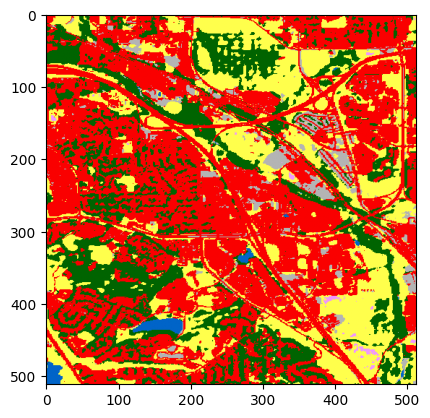

In [7]:
longitude_world = -104.8

latitude_world = 38.8

stac_endopoint = 'https://services.terrascope.be/stac/'

collection_id = 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'

bbox = [longitude_world - 0.02135, latitude_world - 0.02135, longitude_world + 0.02135, latitude_world + 0.02135]

client = Client.open(stac_endopoint)

search_results = client.search(
    collections=collection_id,
    bbox=bbox
)

item = search_results.get_all_items()[0]

# this is to tell GDAL we do not need authentication
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# name of the map asset
asset = 'ESA_WORLDCOVER_10M_MAP'

with STACReader(None, item=item) as stac:
    img = stac.part(bbox, assets=asset)
    
land_use_array = label_to_rgb(img.data[0])


plt.imshow(land_use_array)

### Land use loop

In [14]:
stac_endopoint = 'https://services.terrascope.be/stac/'

collection_id = 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'

In [50]:
start_location = 14000 # where you will start your loop based on the dataframe
end_location = 15415  # where you will end your loop based on the dataframe
target_data = []

for index,row in locations.iloc[start_location:end_location].iterrows():
        
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    bbox = [longitude - 0.02135, latitude - 0.02135, longitude + 0.02135, latitude + 0.02135]

    client = Client.open(stac_endopoint)

    search_results = client.search(
        collections=collection_id,
        bbox=bbox
    )

    item = search_results.get_all_items()[0]

    # this is to tell GDAL we do not need authentication
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

    # name of the map asset
    asset = 'ESA_WORLDCOVER_10M_MAP'

    with STACReader(None, item=item) as stac:
        img = stac.part(bbox, assets=asset)

    land_use_array = label_to_rgb(img.data[0])
    
    target_data.append(land_use_array)
    print(f'at {start_location + len(target_data)} of the arrays')
    
    if len(target_data)%250 == 0:
        target_array = np.array(target_data)
        np.save(f'../raw_data/ESA_worldcover/land_use_data_from_{start_location + len(target_data) - 250}_to_{start_location + len(target_data) - 1}.npy',target_array)
        
        target_data = []
        start_location += 250
        
        continue
    
    
    if start_location + len(target_data) == end_location:
        target_array = np.array(target_data)
        np.save(f'../raw_data/ESA_worldcover/land_use_data_from_{start_location + len(target_data) - 250}_to_{start_location + len(target_data) - 1}.npy',target_array)
        print('Congrats 🎊🎉🥳')
    
    else:
        continue

at 14001 of the arrays
at 14002 of the arrays
at 14003 of the arrays
at 14004 of the arrays
at 14005 of the arrays
at 14006 of the arrays
at 14007 of the arrays
at 14008 of the arrays
at 14009 of the arrays
at 14010 of the arrays
at 14011 of the arrays
at 14012 of the arrays
at 14013 of the arrays
at 14014 of the arrays
at 14015 of the arrays
at 14016 of the arrays
at 14017 of the arrays
at 14018 of the arrays
at 14019 of the arrays
at 14020 of the arrays
at 14021 of the arrays
at 14022 of the arrays
at 14023 of the arrays
at 14024 of the arrays
at 14025 of the arrays
at 14026 of the arrays
at 14027 of the arrays
at 14028 of the arrays
at 14029 of the arrays
at 14030 of the arrays
at 14031 of the arrays
at 14032 of the arrays
at 14033 of the arrays
at 14034 of the arrays
at 14035 of the arrays
at 14036 of the arrays
at 14037 of the arrays
at 14038 of the arrays
at 14039 of the arrays
at 14040 of the arrays
at 14041 of the arrays
at 14042 of the arrays
at 14043 of the arrays
at 14044 of

at 14358 of the arrays
at 14359 of the arrays
at 14360 of the arrays
at 14361 of the arrays
at 14362 of the arrays
at 14363 of the arrays
at 14364 of the arrays
at 14365 of the arrays
at 14366 of the arrays
at 14367 of the arrays
at 14368 of the arrays
at 14369 of the arrays
at 14370 of the arrays
at 14371 of the arrays
at 14372 of the arrays
at 14373 of the arrays
at 14374 of the arrays
at 14375 of the arrays
at 14376 of the arrays
at 14377 of the arrays
at 14378 of the arrays
at 14379 of the arrays
at 14380 of the arrays
at 14381 of the arrays
at 14382 of the arrays
at 14383 of the arrays
at 14384 of the arrays
at 14385 of the arrays
at 14386 of the arrays
at 14387 of the arrays
at 14388 of the arrays
at 14389 of the arrays
at 14390 of the arrays
at 14391 of the arrays
at 14392 of the arrays
at 14393 of the arrays
at 14394 of the arrays
at 14395 of the arrays
at 14396 of the arrays
at 14397 of the arrays
at 14398 of the arrays
at 14399 of the arrays
at 14400 of the arrays
at 14401 of

at 14715 of the arrays
at 14716 of the arrays
at 14717 of the arrays
at 14718 of the arrays
at 14719 of the arrays
at 14720 of the arrays
at 14721 of the arrays
at 14722 of the arrays
at 14723 of the arrays
at 14724 of the arrays
at 14725 of the arrays
at 14726 of the arrays
at 14727 of the arrays
at 14728 of the arrays
at 14729 of the arrays
at 14730 of the arrays
at 14731 of the arrays
at 14732 of the arrays
at 14733 of the arrays
at 14734 of the arrays
at 14735 of the arrays
at 14736 of the arrays
at 14737 of the arrays
at 14738 of the arrays
at 14739 of the arrays
at 14740 of the arrays
at 14741 of the arrays
at 14742 of the arrays
at 14743 of the arrays
at 14744 of the arrays
at 14745 of the arrays
at 14746 of the arrays
at 14747 of the arrays
at 14748 of the arrays
at 14749 of the arrays
at 14750 of the arrays
at 14751 of the arrays
at 14752 of the arrays
at 14753 of the arrays
at 14754 of the arrays
at 14755 of the arrays
at 14756 of the arrays
at 14757 of the arrays
at 14758 of

at 15072 of the arrays
at 15073 of the arrays
at 15074 of the arrays
at 15075 of the arrays
at 15076 of the arrays
at 15077 of the arrays
at 15078 of the arrays
at 15079 of the arrays
at 15080 of the arrays
at 15081 of the arrays
at 15082 of the arrays
at 15083 of the arrays
at 15084 of the arrays
at 15085 of the arrays
at 15086 of the arrays
at 15087 of the arrays
at 15088 of the arrays
at 15089 of the arrays
at 15090 of the arrays
at 15091 of the arrays
at 15092 of the arrays
at 15093 of the arrays
at 15094 of the arrays
at 15095 of the arrays
at 15096 of the arrays
at 15097 of the arrays
at 15098 of the arrays
at 15099 of the arrays
at 15100 of the arrays
at 15101 of the arrays
at 15102 of the arrays
at 15103 of the arrays
at 15104 of the arrays
at 15105 of the arrays
at 15106 of the arrays
at 15107 of the arrays
at 15108 of the arrays
at 15109 of the arrays
at 15110 of the arrays
at 15111 of the arrays
at 15112 of the arrays
at 15113 of the arrays
at 15114 of the arrays
at 15115 of

## NDVI - can I calculate it immediately?

No... pulling pre-calculated NDVI data on Colorado

In [12]:
from PIL import Image

In [35]:
vis_min = 0  # Visualization settings for the image
vis_max = 10_000 # Visualization settings for the image
vis_bands = ['NDVI'] # 
imageDimensions = '512x512' # Set image size: '512x512' for CNN model
year = 2022
id_ = 1

# Centre point for satellite image
longitude = 26.43
latitude = 45.5

center = ee.Geometry.Point(longitude,latitude)

# Import Sentinel 2 data
s2 = (ee.ImageCollection("MODIS/061/MYD13Q1")
  .filterBounds(center)
  .filterDate(f'{year}-07-01', f'{year}-07-30')
  .first()
)

# try:
global sentinel_footprint
exportArea = (ee.Geometry.BBox(west=longitude - 0.4,
                               south=latitude - 0.4,
                               east=longitude + 0.4,
                               north=latitude + 0.4))
# except:
#     print("No Footprint found")
#     continue


s2Vis = {
    'region': exportArea,
    'dimensions': imageDimensions,
    'format': 'png',
    'min': vis_min,
    'max': vis_max,
    'bands': vis_bands
}

s2_url = (s2.getThumbURL(s2Vis))


urllib.request.urlretrieve(s2_url, f"../raw_data/prediction/ndvi_{year}_{longitude}_{latitude}.png")
print(s2_url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17377c96b52649cf18651a7c4c0c505d-b4fa0ae566a545ad3a642ba1e72fc56a:getPixels


Looping through the csv!

In [153]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 0 # where you will start your loop based on the dataframe
end_location = 15415 # where you will end your loop based on the dataframe
year = 2002
for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate(f'{year}-06-01', f'{year}-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_{year}/image{id_}_{longitude}_{latitude}.png")
    
    print(f'number {id_} out')

number 0 out
number 1 out
number 2 out
number 3 out
number 4 out
number 5 out
number 6 out
number 7 out
number 8 out
number 9 out
number 10 out
number 11 out
number 12 out
number 13 out
number 14 out
number 15 out
number 16 out
number 17 out
number 18 out
number 19 out
number 20 out
number 21 out
number 22 out
number 23 out
number 24 out
number 25 out
number 26 out
number 27 out
number 28 out
number 29 out
number 30 out
number 31 out
number 32 out
number 33 out
number 34 out
number 35 out
number 36 out
number 37 out
number 38 out
number 39 out
number 40 out
number 41 out
number 42 out
number 43 out
number 44 out
number 45 out
number 46 out
number 47 out
number 48 out
number 49 out
number 50 out
number 51 out
number 52 out
number 53 out
number 54 out
number 55 out
number 56 out
number 57 out
number 58 out
number 59 out
number 60 out
number 61 out
number 62 out
number 63 out
number 64 out
number 65 out
number 66 out
number 67 out
number 68 out
number 69 out
number 70 out
number 71 out
nu

number 554 out
number 555 out
number 556 out
number 557 out
number 558 out
number 559 out
number 560 out
number 561 out
number 562 out
number 563 out
number 564 out
number 565 out
number 566 out
number 567 out
number 568 out
number 569 out
number 570 out
number 571 out
number 572 out
number 573 out
number 574 out
number 575 out
number 576 out
number 577 out
number 578 out
number 579 out
number 580 out
number 581 out
number 582 out
number 583 out
number 584 out
number 585 out
number 586 out
number 587 out
number 588 out
number 589 out
number 590 out
number 591 out
number 592 out
number 593 out
number 594 out
number 595 out
number 596 out
number 597 out
number 598 out
number 599 out
number 600 out
number 601 out
number 602 out
number 603 out
number 604 out
number 605 out
number 606 out
number 607 out
number 608 out
number 609 out
number 610 out
number 611 out
number 612 out
number 613 out
number 614 out
number 615 out
number 616 out
number 617 out
number 618 out
number 619 out
number 620

KeyboardInterrupt: 